In [3]:
%matplotlib inline

In [4]:
import matplotlib.pylab as plt

In [5]:
import json
import numpy as np
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
from collections import defaultdict

In [6]:
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def readJson(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return df

df = readJson('assignment1/train.json.gz')

In [7]:
trainingData = [df[x] for x in range(0,100000)]
validationData = [df[x] for x in range(100000,200000)]

In [8]:
trainingData[0]

{'categories': [['Clothing, Shoes & Jewelry', 'Women'],
  ['Clothing, Shoes & Jewelry',
   'Novelty, Costumes & More',
   'Novelty',
   'Clothing',
   'Women',
   'Leggings']],
 'categoryID': 0,
 'helpful': {'nHelpful': 0, 'outOf': 0},
 'itemID': 'I655355328',
 'rating': 3.0,
 'reviewHash': 'R115160670',
 'reviewText': 'These are cute, but they are a little small.  When I put them on, my legs stretch the fabric making the black fade out.',
 'reviewTime': '05 20, 2014',
 'reviewerID': 'U745881038',
 'summary': 'Cute',
 'unixReviewTime': 1400544000}

# Problem 1

$\alpha = 0.78373736423168394$

In [9]:
train_nhelpful = np.array([data['helpful']['nHelpful'] for data in trainingData])
train_outOf = np.array([data['helpful']['outOf'] for data in trainingData])
filterZero = np.array(filter(lambda x: x[1] != 0, zip(train_nhelpful, train_outOf)))

In [10]:
alpha = np.mean(filterZero[:,0]*1.0 / filterZero[:,1])
MAE = mean_absolute_error(alpha * train_outOf, train_nhelpful)
alpha, MAE

(0.78373736423168394, 0.2590231482021545)

# Problem 2

Tha validation MAE = 0.25870215742224595

In [11]:
validation_nhelpful = np.array([data['helpful']['nHelpful'] for data in validationData])
validation_outOf = np.array([data['helpful']['outOf'] for data in validationData])
MAE = mean_absolute_error(alpha * validation_outOf, validation_nhelpful)
MAE

0.25870215742224595

# Problem 3
The validation MAE is 0.24024580870415566. The fitted parameters are [  5.62218966e-01,   2.11835412e-04,   5.07029148e-02]

In [12]:
threeFeatureTraining = np.vstack([np.ones(len(train_nhelpful)), \
                                  [len(data['reviewText'].split()) for data in trainingData],\
                                  [data['rating'] for data in trainingData]]).T
filterZero_3 = filter(lambda x: x[2] != 0, zip(threeFeatureTraining, train_nhelpful, train_outOf))
X_train = np.array([x[0] for x in filterZero_3])
y_train = np.array([x[1]*1.0/x[2] for x in filterZero_3])
theta, residuals, rank, s = np.linalg.lstsq(X_train, y_train)

In [13]:
threeFeatureValidation = np.vstack([np.ones(len(validation_nhelpful)),\
                                    [len(data['reviewText'].split()) for data in validationData],\
                                    [data['rating'] for data in validationData]]).T
X_validation = threeFeatureValidation
y_validation = validation_nhelpful
mean_absolute_error(np.dot(X_validation, theta)* validation_outOf, y_validation)


0.24024580870415566

In [14]:
theta

array([  5.62218966e-01,   2.11835412e-04,   5.07029148e-02])

# Problem 4

liuxiyun

In [15]:
reviewDataForTest = readJson('assignment1/test_Helpful.json.gz')
predictions = open("assignment1/predictions_Helpful.txt", 'w')
i = 0
for l in open("assignment1/pairs_Helpful.txt"):
    if l.startswith("userID"):
    #header
        predictions.write(l)
        continue
    user ,item,outOf = l.strip().split('-')
    outOf = int(outOf)
    field = np.array([1, len(reviewDataForTest[i]['reviewText'].split()), reviewDataForTest[i]['rating']])
    predictHelpfulRate = np.dot(field,theta)
    predictions.write(user + '-' + item + '-' + str(outOf) + ',' + str(outOf*predictHelpfulRate) + '\n')
    i += 1
    
predictions.close()

# Problem 5
Alpha is 4.23198, validation MSE = 1.2264713283999997

In [16]:
alpha = sum([data['rating'] for data in trainingData])*1.0/len(trainingData)
alpha

4.23198

In [17]:
mean_squared_error(np.array([data['rating']*1.0 for data in trainingData]), [alpha]*len(trainingData))

1.2276052795999999

In [18]:
mean_squared_error(np.array([data['rating']*1.0 for data in validationData]), [alpha]*len(validationData))

1.2264713283999997

# Problem 6

The value of $\alpha$, $\beta_u$, $\beta_i$ are initialized randomly between 0 to 1. I found the result is different if I initilize all of them as 1. The below result is generate by using randomly inilization. 

Validation MSE = 1.28152763715

In [21]:
userIndex = {}
users = []
userToItem = defaultdict(list)
itemIndex = {}
items = []
itemToUser = defaultdict(list)
i,j = 0,0
for data in trainingData:
    userToItem[data['reviewerID']].append(data['itemID'])
    itemToUser[data['itemID']].append(data['reviewerID'])
    if data['reviewerID'] not in userIndex:
        userIndex[data['reviewerID']] = i
        users.append(data['reviewerID'])
        i += 1
    if data['itemID'] not in itemIndex:
        itemIndex[data['itemID']] = j
        items.append(data['itemID'])
        j += 1

In [22]:
Rui = np.zeros((len(users), len(items)))
for data in trainingData:
    Rui[userIndex[data['reviewerID']]][itemIndex[data['itemID']]] = data['rating']

In [49]:
def gradientDescent(regularization = 1):
    alpha = random.random()
    np.random.seed(0)
    beta_u = np.random.rand(len(userIndex.keys()))
    beta_i = np.random.rand(len(itemIndex.keys()))
#     beta_u = np.ones(len(userIndex.keys()))
#     beta_i = np.ones(len(itemIndex.keys()))
    maxIter = 1e5
    numIter = 0
    alpha_path = []
    beta_u_path = []
    beta_i_path = []
    trainingMSE_path = []
    validationMSE_path = []
    while numIter < maxIter:
        alpha = np.sum([data['rating'] - beta_u[userIndex[data['reviewerID']]] - \
                        beta_i[itemIndex[data['itemID']]] for data in trainingData]) / len(trainingData)
        beta_u = np.array([np.sum([Rui[userIndex[user]][itemIndex[item]] - alpha - \
                                   beta_i[itemIndex[item]] for item in userToItem[user]])
                  /(regularization + len(userToItem[user])) for user in users])
        beta_i = np.array([np.sum([Rui[userIndex[user]][itemIndex[item]] - alpha - \
                                   beta_u[userIndex[user]] for user in itemToUser[item]])
                  /(regularization + len(itemToUser[item])) for item in items])

        trainingMSE = mean_squared_error([alpha + beta_u[userIndex[data['reviewerID']]] + \
                        beta_i[itemIndex[data['itemID']]] for data in trainingData], \
                                        [data['rating'] for data in trainingData])
        # Calculate validation MSE
        prediction = np.zeros(len(validationData)) + alpha
        i = 0
        for data in validationData:
            if data['reviewerID'] in userIndex:
                prediction[i] += beta_u[userIndex[data['reviewerID']]]
            if data['itemID'] in itemIndex:
                prediction[i] += beta_i[itemIndex[data['itemID']]]
            i += 1
        validationMSE = mean_squared_error(prediction, [data['rating'] for data in validationData])

        numIter += 1 
        trainingMSE_path.append(trainingMSE)
        validationMSE_path.append(validationMSE)
        alpha_path.append(alpha)
        beta_u_path.append(beta_u)
        beta_i_path.append(beta_i)
        if len(validationMSE_path) >= 6 and validationMSE_path[-5] <= validationMSE_path[-4] <= \
            validationMSE_path[-3] <= validationMSE_path[-2] <= validationMSE_path[-1]:
            print 'Iteration:', numIter, 'Training MSE =', trainingMSE_path[-5], \
                  ', Validation MSE =', validationMSE_path[-5]
                
            return alpha_path[-5], beta_u_path[-5], beta_i_path[-5], trainingMSE_path[-5], validationMSE_path[-5]

    return alpha, beta_u, beta_i, trainingMSE, validationMSE

In [50]:
alpha, beta_u, beta_i, trainingMSE, validationMSE = gradientDescent()

Iteration: 34 Training MSE = 0.510476039068 , Validation MSE = 1.28152763715


# Problem 7

The value of $\alpha$, $\beta_u$, $\beta_i$ are initialized randomly between 0 to 1. I found the result is different if I initilize all of them as 1.

When I initialize them using randomly inilization, the result is as following.


The user: U816486110 has maximum beta_u: 1.51334345024

The user: U052814411 has minimum beta_u: -2.51296019369

The user: I480796558 has minimum beta_u: 1.25757978675

The item: I071368828 has minimum beta_i: -2.36141470887

When I initialize them as all 1, the result is as following.

The user: U816486110 has maximum beta_u: 1.51332895507

The user: U052814411 has minimum beta_u: -2.51298088476

The item: I558325415 has maximum beta_i: 1.25670020753

The item: I071368828 has minimum beta_i: -2.36214535665

In [51]:
print "The user:", users[np.argmax(beta_u)], 'has maximum beta_u:', np.max(beta_u)

The user: U816486110 has maximum beta_u: 1.51334345024


In [52]:
print "The user:", users[np.argmin(beta_u)], 'has minimum beta_u:', np.min(beta_u)

The user: U052814411 has minimum beta_u: -2.51296019369


In [53]:
print "The item:", items[np.argmax(beta_i)], 'has maximum beta_i:', np.max(beta_i)

The item: I480796558 has maximum beta_i: 1.25757978675


In [54]:
print "The item:", items[np.argmin(beta_i)], 'has minimum beta_i:', np.min(beta_i)

The item: I071368828 has minimum beta_i: -2.36141470887


# Problem 8

When Lambda = 7, the validation MSE is minimum, 1.13959783669

In [92]:
regularizationPath = [0.01,0.1,1,2,3,4,5,6,7,8,9,10,100]
trainingMSE_r_path = []
validationMSE_r_path = []
for regularization in regularizationPath:
    print "lambda: ",regularization
    alpha, beta_u, beta_i,train_MSE,vali_MSE = gradientDescent(regularization)
    trainingMSE_r_path.append(train_MSE)
    validationMSE_r_path.append(vali_MSE)

lambda:  0.01
Iteration: 6 Training MSE = 0.444817173674 , Validation MSE = 1.73362203405
lambda:  0.1
Iteration: 6 Training MSE = 0.447363513364 , Validation MSE = 1.63945530045
lambda:  1
Iteration: 34 Training MSE = 0.510476039068 , Validation MSE = 1.28152763715
lambda:  2
Iteration: 23 Training MSE = 0.59253990334 , Validation MSE = 1.19019987087
lambda:  3
Iteration: 19 Training MSE = 0.655379148685 , Validation MSE = 1.15934850958
lambda:  4
Iteration: 17 Training MSE = 0.705291054966 , Validation MSE = 1.14668375006
lambda:  5
Iteration: 15 Training MSE = 0.746141577503 , Validation MSE = 1.14140526813
lambda:  6
Iteration: 15 Training MSE = 0.780331727511 , Validation MSE = 1.13960946601
lambda:  7
Iteration: 14 Training MSE = 0.80947900874 , Validation MSE = 1.13959783669
lambda:  8
Iteration: 14 Training MSE = 0.834678489993 , Validation MSE = 1.14054326186
lambda:  9
Iteration: 13 Training MSE = 0.856730235325 , Validation MSE = 1.14200666588
lambda:  10
Iteration: 13 Train

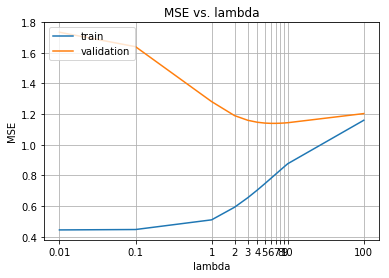

In [119]:
plt.plot(np.log10(regularizationPath),trainingMSE_r_path)    
plt.plot(np.log10(regularizationPath),validationMSE_r_path)
plt.legend(['train', 'validation'], loc='upper left')
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.xticks(np.log10(regularizationPath), regularizationPath)
plt.grid()
plt.title('MSE vs. lambda')

In [122]:
alpha, beta_u, beta_i, _,_ = gradientDescent(regularization=7)
predictions = open("assignment1/predictions_Rating.txt", 'w')
for l in open("assignment1/pairs_Rating.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u,i = l.strip().split('-')
    this_beta_u, this_beta_i = 0,0
    if u in userIndex:
        this_beta_u = beta_u[userIndex[u]]
    if i in itemIndex:
        this_beta_i = beta_i[itemIndex[i]]
        
    predictions.write(u + '-' + i + ',' + str(alpha + this_beta_u + this_beta_i) + '\n')

predictions.close()